# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [66]:
class Config():
    training_dir = "./images/train/"
    testing_dir = "./images/val/"
    train_batch_size = 4
    train_number_epochs = 50

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [5]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [6]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((224,224)),
                                                                      transforms.RandomHorizontalFlip(),
                                                                      transforms.RandomResizedCrop(224,scale=(0.8, 1.0)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

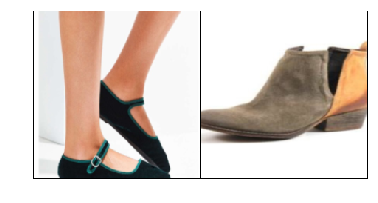

[[1.]]


In [7]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=1)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64), )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128), )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),)
                

        self.fc1 = nn.Sequential(
            nn.Linear(51200, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128))

    def forward_once(self, x):
        output = F.max_pool2d(self.conv1(x), 2)
        output = F.max_pool2d(self.conv2(output), 2)
        output = F.max_pool2d(self.conv3(output), 2)
        output = F.max_pool2d(self.conv4(output), 2)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [9]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [10]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [11]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.001 )

In [12]:
counter = []
loss_history = [] 
iteration_number= 0

In [13]:
len(train_dataloader) 

51

Epoch number 0
 Current loss 1.1822106838226318

Epoch number 1
 Current loss 1.5855436325073242

Epoch number 2
 Current loss 1.55448317527771

Epoch number 3
 Current loss 1.6771750450134277

Epoch number 4
 Current loss 1.984902024269104

Epoch number 5
 Current loss 1.2150347232818604

Epoch number 6
 Current loss 0.322119802236557

Epoch number 7
 Current loss 1.056003212928772

Epoch number 8
 Current loss 1.001222014427185

Epoch number 9
 Current loss 0.2754022181034088

Epoch number 10
 Current loss 0.37366342544555664

Epoch number 11
 Current loss 1.2586675882339478

Epoch number 12
 Current loss 1.3683664798736572

Epoch number 13
 Current loss 1.3547948598861694

Epoch number 14
 Current loss 1.8937339782714844

Epoch number 15
 Current loss 1.4156256914138794

Epoch number 16
 Current loss 0.8146997690200806

Epoch number 17
 Current loss 1.4192641973495483

Epoch number 18
 Current loss 1.013122320175171

Epoch number 19
 Current loss 1.1819859743118286

Epoch number 20


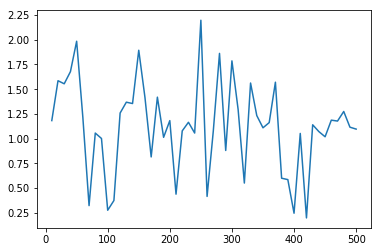

In [14]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        
    print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
    iteration_number +=10
    counter.append(iteration_number)
    loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [15]:
torch.save(net.state_dict(), './models/siamese_network_clothess_v1.pth')

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

loading dataset
starting
tensor([[ 0.0566,  0.0435, -0.0882,  0.0564,  0.0186,  0.1031, -0.0539,  0.1715,
          0.1790,  0.1225, -0.1111,  0.0828,  0.1026, -0.0250, -0.0142, -0.1692,
          0.0624, -0.0090,  0.1874,  0.1162, -0.1635, -0.0624, -0.0055, -0.1779,
         -0.0071,  0.0442,  0.0584, -0.0460, -0.0030,  0.1083,  0.2601, -0.1838,
          0.1931,  0.1860,  0.1296,  0.1873,  0.0025, -0.2497,  0.1746,  0.0129,
          0.0052,  0.0076, -0.1978, -0.1493,  0.0080,  0.0624,  0.1223,  0.1478,
         -0.0146,  0.0616, -0.1176,  0.1852, -0.1747,  0.0248, -0.0105, -0.0471,
          0.0141,  0.0285,  0.0487, -0.0455,  0.0159,  0.0924,  0.1473, -0.0512,
          0.0618,  0.0993,  0.0008,  0.1280,  0.1484, -0.0530, -0.0558, -0.0772,
          0.1762,  0.1042,  0.1516, -0.0380, -0.0412,  0.1353, -0.1598,  0.0906,
          0.0735, -0.0750,  0.1930, -0.0195, -0.0491,  0.1322, -0.0039,  0.2165,
         -0.0582,  0.0622,  0.0371, -0.1142,  0.0692,  0.0441,  0.1241,  0.0654,
   

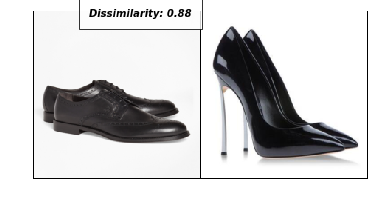

tensor([[ 0.0566,  0.0435, -0.0882,  0.0564,  0.0186,  0.1031, -0.0539,  0.1715,
          0.1790,  0.1225, -0.1111,  0.0828,  0.1026, -0.0250, -0.0142, -0.1692,
          0.0624, -0.0090,  0.1874,  0.1162, -0.1635, -0.0624, -0.0055, -0.1779,
         -0.0071,  0.0442,  0.0584, -0.0460, -0.0030,  0.1083,  0.2601, -0.1838,
          0.1931,  0.1860,  0.1296,  0.1873,  0.0025, -0.2497,  0.1746,  0.0129,
          0.0052,  0.0076, -0.1978, -0.1493,  0.0080,  0.0624,  0.1223,  0.1478,
         -0.0146,  0.0616, -0.1176,  0.1852, -0.1747,  0.0248, -0.0105, -0.0471,
          0.0141,  0.0285,  0.0487, -0.0455,  0.0159,  0.0924,  0.1473, -0.0512,
          0.0618,  0.0993,  0.0008,  0.1280,  0.1484, -0.0530, -0.0558, -0.0772,
          0.1762,  0.1042,  0.1516, -0.0380, -0.0412,  0.1353, -0.1598,  0.0906,
          0.0735, -0.0750,  0.1930, -0.0195, -0.0491,  0.1322, -0.0039,  0.2165,
         -0.0582,  0.0622,  0.0371, -0.1142,  0.0692,  0.0441,  0.1241,  0.0654,
         -0.0223,  0.0797, -

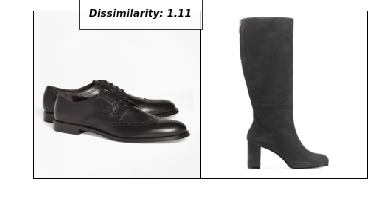

tensor([[ 0.0566,  0.0435, -0.0882,  0.0564,  0.0186,  0.1031, -0.0539,  0.1715,
          0.1790,  0.1225, -0.1111,  0.0828,  0.1026, -0.0250, -0.0142, -0.1692,
          0.0624, -0.0090,  0.1874,  0.1162, -0.1635, -0.0624, -0.0055, -0.1779,
         -0.0071,  0.0442,  0.0584, -0.0460, -0.0030,  0.1083,  0.2601, -0.1838,
          0.1931,  0.1860,  0.1296,  0.1873,  0.0025, -0.2497,  0.1746,  0.0129,
          0.0052,  0.0076, -0.1978, -0.1493,  0.0080,  0.0624,  0.1223,  0.1478,
         -0.0146,  0.0616, -0.1176,  0.1852, -0.1747,  0.0248, -0.0105, -0.0471,
          0.0141,  0.0285,  0.0487, -0.0455,  0.0159,  0.0924,  0.1473, -0.0512,
          0.0618,  0.0993,  0.0008,  0.1280,  0.1484, -0.0530, -0.0558, -0.0772,
          0.1762,  0.1042,  0.1516, -0.0380, -0.0412,  0.1353, -0.1598,  0.0906,
          0.0735, -0.0750,  0.1930, -0.0195, -0.0491,  0.1322, -0.0039,  0.2165,
         -0.0582,  0.0622,  0.0371, -0.1142,  0.0692,  0.0441,  0.1241,  0.0654,
         -0.0223,  0.0797, -

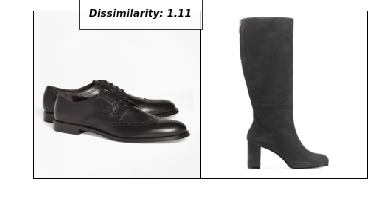

tensor([[ 0.0566,  0.0435, -0.0882,  0.0564,  0.0186,  0.1031, -0.0539,  0.1715,
          0.1790,  0.1225, -0.1111,  0.0828,  0.1026, -0.0250, -0.0142, -0.1692,
          0.0624, -0.0090,  0.1874,  0.1162, -0.1635, -0.0624, -0.0055, -0.1779,
         -0.0071,  0.0442,  0.0584, -0.0460, -0.0030,  0.1083,  0.2601, -0.1838,
          0.1931,  0.1860,  0.1296,  0.1873,  0.0025, -0.2497,  0.1746,  0.0129,
          0.0052,  0.0076, -0.1978, -0.1493,  0.0080,  0.0624,  0.1223,  0.1478,
         -0.0146,  0.0616, -0.1176,  0.1852, -0.1747,  0.0248, -0.0105, -0.0471,
          0.0141,  0.0285,  0.0487, -0.0455,  0.0159,  0.0924,  0.1473, -0.0512,
          0.0618,  0.0993,  0.0008,  0.1280,  0.1484, -0.0530, -0.0558, -0.0772,
          0.1762,  0.1042,  0.1516, -0.0380, -0.0412,  0.1353, -0.1598,  0.0906,
          0.0735, -0.0750,  0.1930, -0.0195, -0.0491,  0.1322, -0.0039,  0.2165,
         -0.0582,  0.0622,  0.0371, -0.1142,  0.0692,  0.0441,  0.1241,  0.0654,
         -0.0223,  0.0797, -

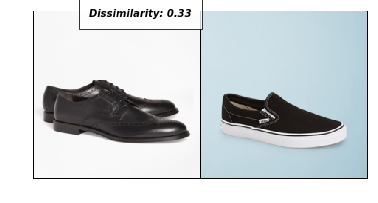

tensor([[ 0.0566,  0.0435, -0.0882,  0.0564,  0.0186,  0.1031, -0.0539,  0.1715,
          0.1790,  0.1225, -0.1111,  0.0828,  0.1026, -0.0250, -0.0142, -0.1692,
          0.0624, -0.0090,  0.1874,  0.1162, -0.1635, -0.0624, -0.0055, -0.1779,
         -0.0071,  0.0442,  0.0584, -0.0460, -0.0030,  0.1083,  0.2601, -0.1838,
          0.1931,  0.1860,  0.1296,  0.1873,  0.0025, -0.2497,  0.1746,  0.0129,
          0.0052,  0.0076, -0.1978, -0.1493,  0.0080,  0.0624,  0.1223,  0.1478,
         -0.0146,  0.0616, -0.1176,  0.1852, -0.1747,  0.0248, -0.0105, -0.0471,
          0.0141,  0.0285,  0.0487, -0.0455,  0.0159,  0.0924,  0.1473, -0.0512,
          0.0618,  0.0993,  0.0008,  0.1280,  0.1484, -0.0530, -0.0558, -0.0772,
          0.1762,  0.1042,  0.1516, -0.0380, -0.0412,  0.1353, -0.1598,  0.0906,
          0.0735, -0.0750,  0.1930, -0.0195, -0.0491,  0.1322, -0.0039,  0.2165,
         -0.0582,  0.0622,  0.0371, -0.1142,  0.0692,  0.0441,  0.1241,  0.0654,
         -0.0223,  0.0797, -

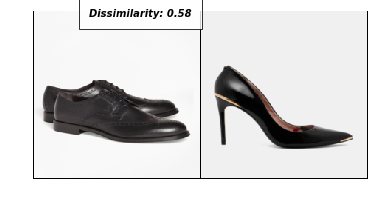

tensor([[ 0.0566,  0.0435, -0.0882,  0.0564,  0.0186,  0.1031, -0.0539,  0.1715,
          0.1790,  0.1225, -0.1111,  0.0828,  0.1026, -0.0250, -0.0142, -0.1692,
          0.0624, -0.0090,  0.1874,  0.1162, -0.1635, -0.0624, -0.0055, -0.1779,
         -0.0071,  0.0442,  0.0584, -0.0460, -0.0030,  0.1083,  0.2601, -0.1838,
          0.1931,  0.1860,  0.1296,  0.1873,  0.0025, -0.2497,  0.1746,  0.0129,
          0.0052,  0.0076, -0.1978, -0.1493,  0.0080,  0.0624,  0.1223,  0.1478,
         -0.0146,  0.0616, -0.1176,  0.1852, -0.1747,  0.0248, -0.0105, -0.0471,
          0.0141,  0.0285,  0.0487, -0.0455,  0.0159,  0.0924,  0.1473, -0.0512,
          0.0618,  0.0993,  0.0008,  0.1280,  0.1484, -0.0530, -0.0558, -0.0772,
          0.1762,  0.1042,  0.1516, -0.0380, -0.0412,  0.1353, -0.1598,  0.0906,
          0.0735, -0.0750,  0.1930, -0.0195, -0.0491,  0.1322, -0.0039,  0.2165,
         -0.0582,  0.0622,  0.0371, -0.1142,  0.0692,  0.0441,  0.1241,  0.0654,
         -0.0223,  0.0797, -

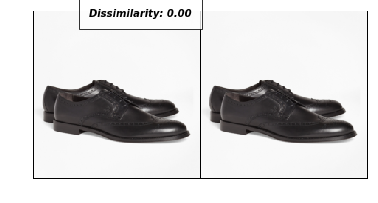

tensor([[ 0.0566,  0.0435, -0.0882,  0.0564,  0.0186,  0.1031, -0.0539,  0.1715,
          0.1790,  0.1225, -0.1111,  0.0828,  0.1026, -0.0250, -0.0142, -0.1692,
          0.0624, -0.0090,  0.1874,  0.1162, -0.1635, -0.0624, -0.0055, -0.1779,
         -0.0071,  0.0442,  0.0584, -0.0460, -0.0030,  0.1083,  0.2601, -0.1838,
          0.1931,  0.1860,  0.1296,  0.1873,  0.0025, -0.2497,  0.1746,  0.0129,
          0.0052,  0.0076, -0.1978, -0.1493,  0.0080,  0.0624,  0.1223,  0.1478,
         -0.0146,  0.0616, -0.1176,  0.1852, -0.1747,  0.0248, -0.0105, -0.0471,
          0.0141,  0.0285,  0.0487, -0.0455,  0.0159,  0.0924,  0.1473, -0.0512,
          0.0618,  0.0993,  0.0008,  0.1280,  0.1484, -0.0530, -0.0558, -0.0772,
          0.1762,  0.1042,  0.1516, -0.0380, -0.0412,  0.1353, -0.1598,  0.0906,
          0.0735, -0.0750,  0.1930, -0.0195, -0.0491,  0.1322, -0.0039,  0.2165,
         -0.0582,  0.0622,  0.0371, -0.1142,  0.0692,  0.0441,  0.1241,  0.0654,
         -0.0223,  0.0797, -

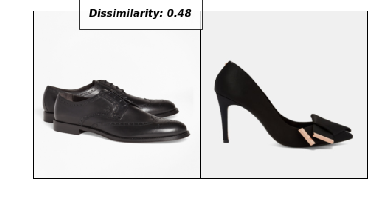

tensor([[ 0.0566,  0.0435, -0.0882,  0.0564,  0.0186,  0.1031, -0.0539,  0.1715,
          0.1790,  0.1225, -0.1111,  0.0828,  0.1026, -0.0250, -0.0142, -0.1692,
          0.0624, -0.0090,  0.1874,  0.1162, -0.1635, -0.0624, -0.0055, -0.1779,
         -0.0071,  0.0442,  0.0584, -0.0460, -0.0030,  0.1083,  0.2601, -0.1838,
          0.1931,  0.1860,  0.1296,  0.1873,  0.0025, -0.2497,  0.1746,  0.0129,
          0.0052,  0.0076, -0.1978, -0.1493,  0.0080,  0.0624,  0.1223,  0.1478,
         -0.0146,  0.0616, -0.1176,  0.1852, -0.1747,  0.0248, -0.0105, -0.0471,
          0.0141,  0.0285,  0.0487, -0.0455,  0.0159,  0.0924,  0.1473, -0.0512,
          0.0618,  0.0993,  0.0008,  0.1280,  0.1484, -0.0530, -0.0558, -0.0772,
          0.1762,  0.1042,  0.1516, -0.0380, -0.0412,  0.1353, -0.1598,  0.0906,
          0.0735, -0.0750,  0.1930, -0.0195, -0.0491,  0.1322, -0.0039,  0.2165,
         -0.0582,  0.0622,  0.0371, -0.1142,  0.0692,  0.0441,  0.1241,  0.0654,
         -0.0223,  0.0797, -

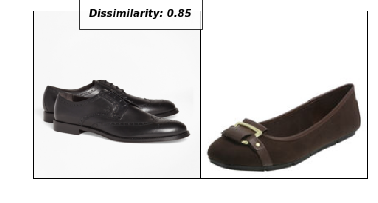

tensor([[ 0.0566,  0.0435, -0.0882,  0.0564,  0.0186,  0.1031, -0.0539,  0.1715,
          0.1790,  0.1225, -0.1111,  0.0828,  0.1026, -0.0250, -0.0142, -0.1692,
          0.0624, -0.0090,  0.1874,  0.1162, -0.1635, -0.0624, -0.0055, -0.1779,
         -0.0071,  0.0442,  0.0584, -0.0460, -0.0030,  0.1083,  0.2601, -0.1838,
          0.1931,  0.1860,  0.1296,  0.1873,  0.0025, -0.2497,  0.1746,  0.0129,
          0.0052,  0.0076, -0.1978, -0.1493,  0.0080,  0.0624,  0.1223,  0.1478,
         -0.0146,  0.0616, -0.1176,  0.1852, -0.1747,  0.0248, -0.0105, -0.0471,
          0.0141,  0.0285,  0.0487, -0.0455,  0.0159,  0.0924,  0.1473, -0.0512,
          0.0618,  0.0993,  0.0008,  0.1280,  0.1484, -0.0530, -0.0558, -0.0772,
          0.1762,  0.1042,  0.1516, -0.0380, -0.0412,  0.1353, -0.1598,  0.0906,
          0.0735, -0.0750,  0.1930, -0.0195, -0.0491,  0.1322, -0.0039,  0.2165,
         -0.0582,  0.0622,  0.0371, -0.1142,  0.0692,  0.0441,  0.1241,  0.0654,
         -0.0223,  0.0797, -

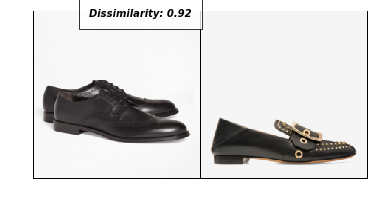

tensor([[ 0.0566,  0.0435, -0.0882,  0.0564,  0.0186,  0.1031, -0.0539,  0.1715,
          0.1790,  0.1225, -0.1111,  0.0828,  0.1026, -0.0250, -0.0142, -0.1692,
          0.0624, -0.0090,  0.1874,  0.1162, -0.1635, -0.0624, -0.0055, -0.1779,
         -0.0071,  0.0442,  0.0584, -0.0460, -0.0030,  0.1083,  0.2601, -0.1838,
          0.1931,  0.1860,  0.1296,  0.1873,  0.0025, -0.2497,  0.1746,  0.0129,
          0.0052,  0.0076, -0.1978, -0.1493,  0.0080,  0.0624,  0.1223,  0.1478,
         -0.0146,  0.0616, -0.1176,  0.1852, -0.1747,  0.0248, -0.0105, -0.0471,
          0.0141,  0.0285,  0.0487, -0.0455,  0.0159,  0.0924,  0.1473, -0.0512,
          0.0618,  0.0993,  0.0008,  0.1280,  0.1484, -0.0530, -0.0558, -0.0772,
          0.1762,  0.1042,  0.1516, -0.0380, -0.0412,  0.1353, -0.1598,  0.0906,
          0.0735, -0.0750,  0.1930, -0.0195, -0.0491,  0.1322, -0.0039,  0.2165,
         -0.0582,  0.0622,  0.0371, -0.1142,  0.0692,  0.0441,  0.1241,  0.0654,
         -0.0223,  0.0797, -

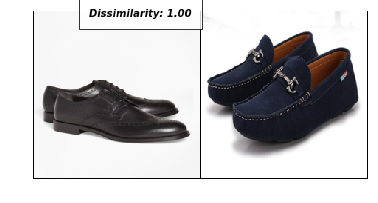

tensor([[ 0.0566,  0.0435, -0.0882,  0.0564,  0.0186,  0.1031, -0.0539,  0.1715,
          0.1790,  0.1225, -0.1111,  0.0828,  0.1026, -0.0250, -0.0142, -0.1692,
          0.0624, -0.0090,  0.1874,  0.1162, -0.1635, -0.0624, -0.0055, -0.1779,
         -0.0071,  0.0442,  0.0584, -0.0460, -0.0030,  0.1083,  0.2601, -0.1838,
          0.1931,  0.1860,  0.1296,  0.1873,  0.0025, -0.2497,  0.1746,  0.0129,
          0.0052,  0.0076, -0.1978, -0.1493,  0.0080,  0.0624,  0.1223,  0.1478,
         -0.0146,  0.0616, -0.1176,  0.1852, -0.1747,  0.0248, -0.0105, -0.0471,
          0.0141,  0.0285,  0.0487, -0.0455,  0.0159,  0.0924,  0.1473, -0.0512,
          0.0618,  0.0993,  0.0008,  0.1280,  0.1484, -0.0530, -0.0558, -0.0772,
          0.1762,  0.1042,  0.1516, -0.0380, -0.0412,  0.1353, -0.1598,  0.0906,
          0.0735, -0.0750,  0.1930, -0.0195, -0.0491,  0.1322, -0.0039,  0.2165,
         -0.0582,  0.0622,  0.0371, -0.1142,  0.0692,  0.0441,  0.1241,  0.0654,
         -0.0223,  0.0797, -

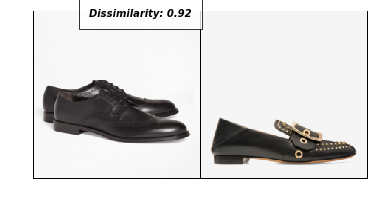

tensor([[ 0.0566,  0.0435, -0.0882,  0.0564,  0.0186,  0.1031, -0.0539,  0.1715,
          0.1790,  0.1225, -0.1111,  0.0828,  0.1026, -0.0250, -0.0142, -0.1692,
          0.0624, -0.0090,  0.1874,  0.1162, -0.1635, -0.0624, -0.0055, -0.1779,
         -0.0071,  0.0442,  0.0584, -0.0460, -0.0030,  0.1083,  0.2601, -0.1838,
          0.1931,  0.1860,  0.1296,  0.1873,  0.0025, -0.2497,  0.1746,  0.0129,
          0.0052,  0.0076, -0.1978, -0.1493,  0.0080,  0.0624,  0.1223,  0.1478,
         -0.0146,  0.0616, -0.1176,  0.1852, -0.1747,  0.0248, -0.0105, -0.0471,
          0.0141,  0.0285,  0.0487, -0.0455,  0.0159,  0.0924,  0.1473, -0.0512,
          0.0618,  0.0993,  0.0008,  0.1280,  0.1484, -0.0530, -0.0558, -0.0772,
          0.1762,  0.1042,  0.1516, -0.0380, -0.0412,  0.1353, -0.1598,  0.0906,
          0.0735, -0.0750,  0.1930, -0.0195, -0.0491,  0.1322, -0.0039,  0.2165,
         -0.0582,  0.0622,  0.0371, -0.1142,  0.0692,  0.0441,  0.1241,  0.0654,
         -0.0223,  0.0797, -

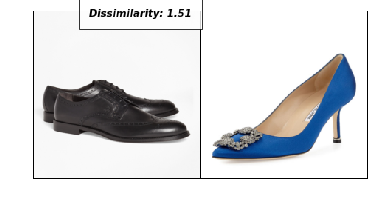

In [92]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((224,224)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
print('loading dataset')
test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)
net.eval()
print('starting')
for i in range(12):
    _,x1,label2 = next(dataiter)
    #print(x1.shape)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    print(output1)
    print('')
    print(output2)
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



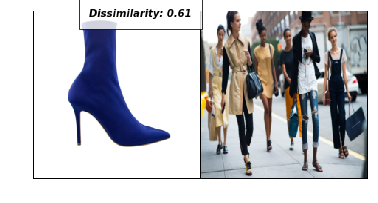

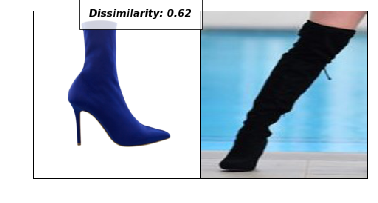

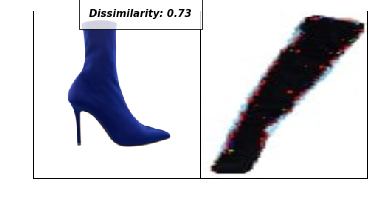

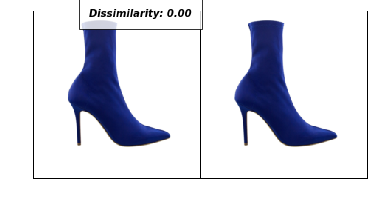

In [113]:
net.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


scale=transforms.Compose([transforms.Resize((224,224)),
                            transforms.ToTensor()
                             ])


base_card = Image.open('forblog/davis.bl-ststn_default_1.jpg')

base_card = scale(base_card).unsqueeze(0)

raw_card_list = [Image.open('forblog/7454-Le-21eme-Adam-Katz-Sinding-After-31-Phillip-Lim-Mercedes-Benz-New-York-Fashion-Week-Spring-Summer-2015_AKS6971-900x599.jpg'),
    Image.open('forblog/unsegmented.jpg'),
                 Image.open('forblog/unseg2.jpg'),
                 Image.open('forblog/davis.bl-ststn_default_1.jpg')]

for img in raw_card_list:
        #print(img.shape)
        img = scale(img).unsqueeze(0)
        concatenated = torch.cat((base_card,img),0)
        outputa,outputb = net(base_card.cuda(),img.cuda())
        euclidean_distance = F.pairwise_distance(outputa, outputb)
        imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

